<a href="https://www.kaggle.com/code/franciscangeno/predicting-rtc-severity-in-uk-roads-using-machine?scriptVersionId=113176975" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  mean_absolute_error,r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/road-traffic-collision-dataset/vehicle_data.csv
/kaggle/input/road-traffic-collision-dataset/accident_data.csv


In [2]:
accidentdf = pd.read_csv("../input/road-traffic-collision-dataset/accident_data.csv",parse_dates=['Date'])

In [3]:
accidentdf.sample(6)

,Accident_Index,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Carriageway_Hazards,Date,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,Junction_Control,Junction_Detail,Latitude,Light_Conditions,Local_Authority_(District),Local_Authority_(Highway),Location_Easting_OSGR,Location_Northing_OSGR,Longitude,LSOA_of_Accident_Location,Number_of_Casualties,Number_of_Vehicles,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Year,InScotland
435587,2.0071E+12,NaN,416.0,Unclassified,416.0,Slight,None,2007-11-08,Saturday,1.0,Give way or uncontrolled,T or staggered junction,54.959185,Daylight,Gateshead,Gateshead,417750.0,562760.0,-1.724330,E01008180,2,2,0.0,0.0,Northumbria,Dry,Single carriageway,None,30,19:30,Urban,Fine no high winds,2007,No
644416,2.00822E+12,NaN,42.0,NaN,0.0,Slight,None,2008-09-03,Sunday,1.0,Data missing or out of range,Not at junction or within 20 metres,53.030551,Darkness - lights lit,Stoke-on-Trent,Stoke-on-Trent,387240.0,348160.0,-2.191725,E01014285,2,2,0.0,0.0,Staffordshire,Dry,Single carriageway,None,30,21:47,Urban,Fine no high winds,2008,No
208588,200601LX50585,NaN,0.0,Unclassified,0.0,Serious,None,2006-07-27,Thursday,1.0,Give way or uncontrolled,T or staggered junction,51.430066,Daylight,Lambeth,Lambeth,529600.0,171770.0,-0.137109,E01003119,1,1,0.0,0.0,Metropolitan Police,Dry,Single carriageway,None,30,16:45,Urban,Fine no high winds,2006,No
1001508,20104100K0544,NaN,297.0,B,176.0,Slight,None,2010-10-31,Sunday,1.0,Give way or uncontrolled,Mini-roundabout,51.691960,Daylight,Broxbourne,Hertfordshire,535980.0,201080.0,-0.034061,E01023332,1,3,0.0,0.0,Hertfordshire,Wet or damp,Single carriageway,None,30,13:25,Urban,Fine no high winds,2010,No
499507,20074100G0321,A,505.0,A,505.0,Slight,None,2007-10-05,Thursday,1.0,Give way or uncontrolled,Roundabout,51.970528,Darkness - lights lit,North Hertfordshire,Hertfordshire,522810.0,231740.0,-0.213628,E01023647,1,2,0.0,0.0,Hertfordshire,Wet or damp,Single carriageway,None,40,23:00,Urban,Raining no high winds,2007,No
225079,2.00603E+12,C,3199.0,NaN,0.0,Slight,Other object on road,2006-11-30,Thursday,2.0,Data missing or out of range,Not at junction or within 20 metres,54.630734,Daylight,Eden,Cumbria,362770.0,526330.0,-2.578233,E01019319,1,1,0.0,0.0,Cumbria,Wet or damp,Single carriageway,Mud,60,14:02,Rural,Fine no high winds,2006,No


In [4]:
accidentdf.describe().T.style

,count,mean,std,min,25%,50%,75%,max
1st_Road_Number,1048573.000000,1011.997007,1832.041637,0.000000,0.000000,125.000000,706.000000,9999.000000
2nd_Road_Number,1037772.000000,387.000433,1316.672921,0.000000,0.000000,0.000000,0.000000,9999.000000
Did_Police_Officer_Attend_Scene_of_Accident,1048306.000000,1.198669,0.406263,1.000000,1.000000,1.000000,1.000000,3.000000
Latitude,1048464.000000,52.572970,1.424463,49.914430,51.492443,52.343142,53.464070,60.757544
Location_Easting_OSGR,1048464.000000,438307.694984,94792.918660,64950.000000,375220.000000,437700.000000,521160.000000,655540.000000
Location_Northing_OSGR,1048464.000000,298312.981282,158175.671919,10520.000000,178470.000000,272930.000000,396550.000000,1208800.000000
Longitude,1048463.000000,-1.454537,1.391890,-7.516225,-2.371331,-1.435624,-0.244605,1.762010
Number_of_Casualties,1048575.000000,1.359930,0.822365,1.000000,1.000000,1.000000,1.000000,68.000000
Number_of_Vehicles,1048575.000000,1.835030,0.718145,1.000000,1.000000,2.000000,2.000000,32.000000
Pedestrian_Crossing-Human_Control,1048554.000000,0.009292,0.126723,0.000000,0.000000,0.000000,0.000000,2.000000


# NOTES
1. 1st_Road_Number ranges from 0 to 9999 where 1/4 of the values is 0 and minimum is 0.
2. 2nd_Road_Number ranges from 0-9999 and 3/4 of the numbers is 0.
* However, road numbers cannot be 0 so 0 here means null 
3. Did_Police_Officer_Attend_Scene_of_Accident ranges from 1-3. 3/4 is 1 and 1 is the minimum.
4. Latitude ranges from 49-60, minimum is 49.
5. Longitude ranges from -7.5 to 1.7.
6. Pedestrian_Crossing_Human_Control,Pedestrian_Crossing-Physical_Facilities ranges from 0-2 and 0 is really a zero. Not a missing value, majority is 0. 

In [5]:
# replacing zero values as missing
accidentdf['1st_Road_Number'].replace(0, np.NaN, inplace = True)
accidentdf['2nd_Road_Number'].replace(0, np.NaN, inplace = True)


In [6]:
nums = accidentdf.describe().T.style

In [7]:
!pip install missingno

In [8]:
import missingno as mno
# extract a list of null columns
null_columns = pd.DataFrame(accidentdf[accidentdf.columns[accidentdf.isnull().any()]].isnull().sum()*100/ accidentdf.shape[0], columns =["Percentage of null values"])
null_columns["Total Nan Values"]=accidentdf[accidentdf.columns[accidentdf.isnull().any()]].isnull().sum()
null_columns

,Percentage of null values,Total Nan Values
1st_Road_Class,29.143266,305589
1st_Road_Number,27.355888,286847
2nd_Road_Class,41.944925,439824
2nd_Road_Number,78.519610,823337
Carriageway_Hazards,0.002766,29
Did_Police_Officer_Attend_Scene_of_Accident,0.025654,269
Latitude,0.010586,111
Light_Conditions,0.198746,2084
Location_Easting_OSGR,0.010586,111
Location_Northing_OSGR,0.010586,111


First road class, second road class, lsoa of accident have a lot of missing values.The rest have less than 5% missing values

In [9]:
# make a list of colums that have null values
null_cols = null_columns.index.tolist()
print(type(null_cols))
print(null_cols)

<class 'list'>
['1st_Road_Class', '1st_Road_Number', '2nd_Road_Class', '2nd_Road_Number', 'Carriageway_Hazards', 'Did_Police_Officer_Attend_Scene_of_Accident', 'Latitude', 'Light_Conditions', 'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 'LSOA_of_Accident_Location', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site', 'Time', 'Urban_or_Rural_Area', 'Weather_Conditions', 'InScotland']


<AxesSubplot:>

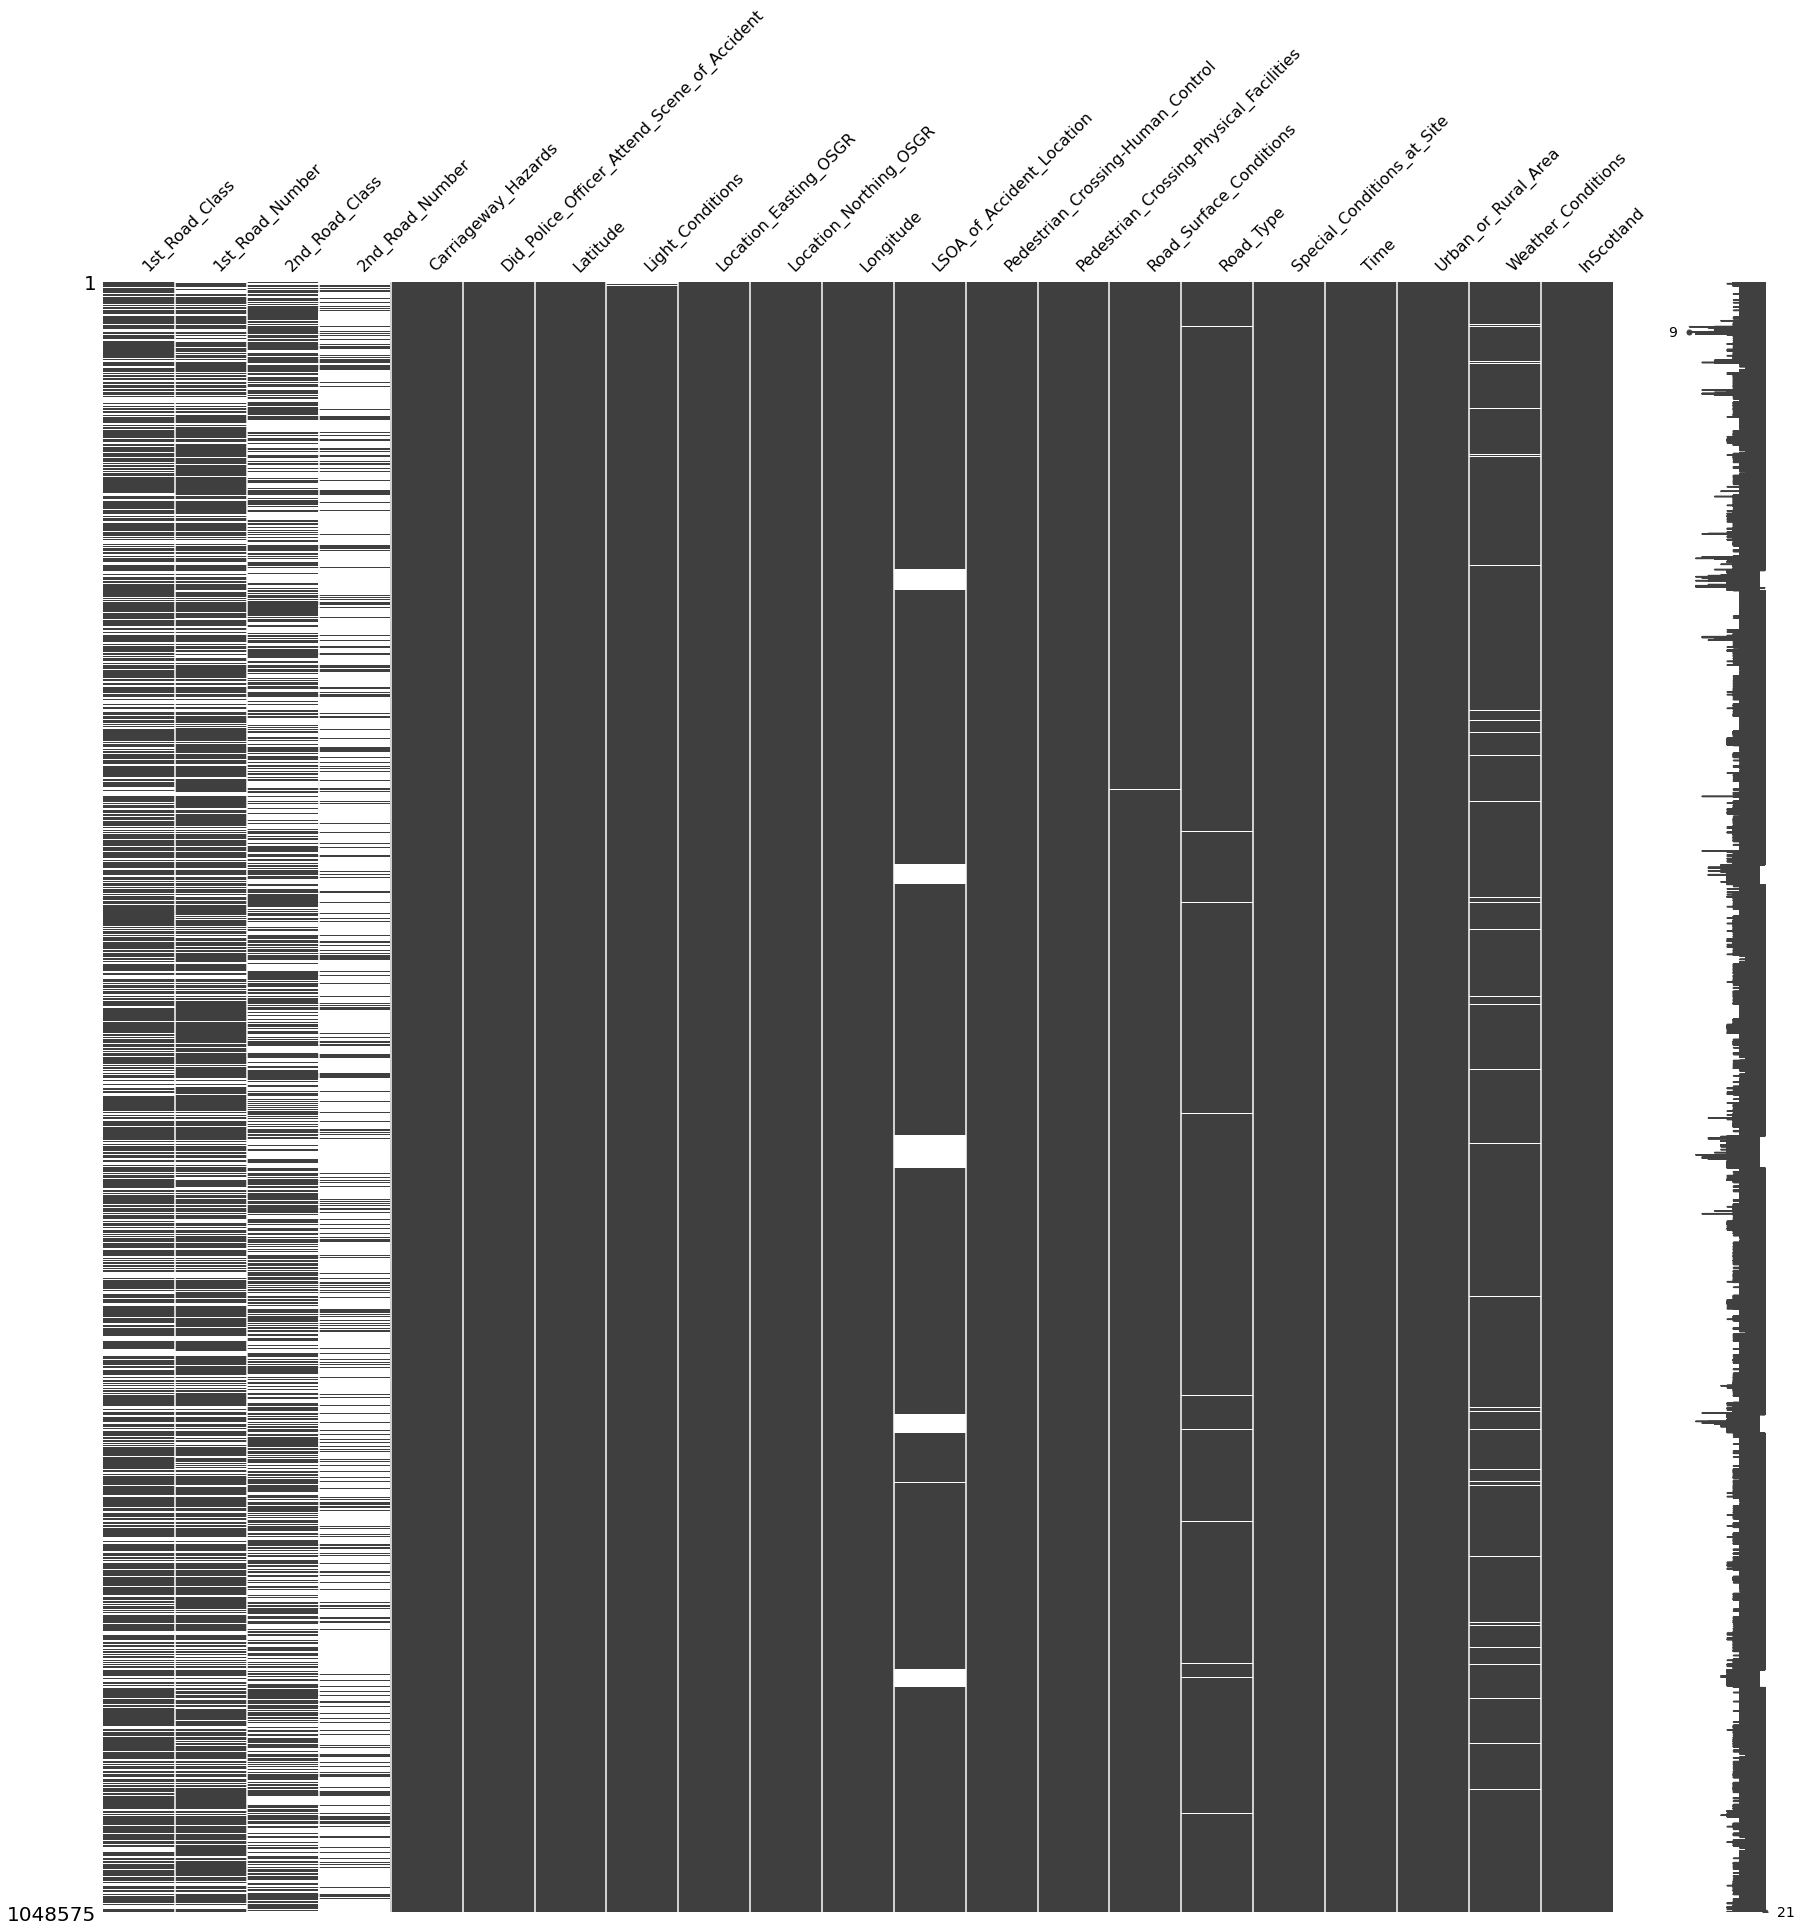

In [10]:
# where exactly are the values missing?
mno.matrix(accidentdf[null_cols], figsize=(30,30))

In [11]:
# shape of the data 
print("No of rows in the acident data is",accidentdf.shape[0])
print("No of columns in the accident data is", accidentdf.shape[1])

No of rows in the acident data is 1048575
No of columns in the accident data is 34


In [12]:
accidentdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 34 columns):
 #   Column                                       Non-Null Count    Dtype         
---  ------                                       --------------    -----         
 0   Accident_Index                               1048575 non-null  object        
 1   1st_Road_Class                               742986 non-null   object        
 2   1st_Road_Number                              761728 non-null   float64       
 3   2nd_Road_Class                               608751 non-null   object        
 4   2nd_Road_Number                              225238 non-null   float64       
 5   Accident_Severity                            1048575 non-null  object        
 6   Carriageway_Hazards                          1048546 non-null  object        
 7   Date                                         1048575 non-null  datetime64[ns]
 8   Day_of_Week                                  1048575

In [13]:
# find duplicate entries

print("Duplicate entries:", accidentdf.duplicated().sum())
accidentdf = accidentdf.drop_duplicates(keep=False)
print("Duplicate entries:", accidentdf.duplicated().sum())

Duplicate entries: 6
Duplicate entries: 0


In [14]:
# how many unique values to know what to datatypes to change
# to see all the columns
pd.set_option('Display.max_rows', None)
# nunique counts the unique values in every column and dropna=true means we ignore nan values and .sort sorts the values in ascending order
print(accidentdf.nunique(dropna=True).sort_values())


InScotland                                          2
Accident_Severity                                   3
Did_Police_Officer_Attend_Scene_of_Accident         3
Pedestrian_Crossing-Human_Control                   3
Urban_or_Rural_Area                                 3
1st_Road_Class                                      5
Road_Type                                           5
Road_Surface_Conditions                             5
Light_Conditions                                    5
2nd_Road_Class                                      6
Carriageway_Hazards                                 6
Pedestrian_Crossing-Physical_Facilities             6
Year                                                6
Day_of_Week                                         7
Junction_Control                                    7
Speed_limit                                         8
Weather_Conditions                                  8
Special_Conditions_at_Site                         10
Junction_Detail             

In [15]:
for column in accidentdf.columns:
    print(column + ":" + str(len(accidentdf[column].unique())))
    if(len(accidentdf[column].unique())<100):
        print(column + ':' + str(accidentdf[column].unique()))
    print('\n')

Accident_Index:671340


1st_Road_Class:6
1st_Road_Class:['A' 'B' 'C' nan 'Motorway' 'A(M)']


1st_Road_Number:6552


2nd_Road_Class:7
2nd_Road_Class:[nan 'C' 'Unclassified' 'B' 'A' 'Motorway' 'A(M)']


2nd_Road_Number:6939


Accident_Severity:3
Accident_Severity:['Serious' 'Slight' 'Fatal']


Carriageway_Hazards:7
Carriageway_Hazards:['None' 'Other object on road' 'Pedestrian in carriageway - not injured'
 'Vehicle load on road' 'Previous accident'
 'Any animal in carriageway (except ridden horse)' nan]


Date:2191


Day_of_Week:7
Day_of_Week:['Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Monday' 'Saturday' 'Sunday']


Did_Police_Officer_Attend_Scene_of_Accident:4
Did_Police_Officer_Attend_Scene_of_Accident:[ 1.  2.  3. nan]


Junction_Control:7
Junction_Control:['Data missing or out of range' 'Auto traffic signal'
 'Give way or uncontrolled' 'Stop sign' 'Authorised person'
 'Auto traffic sigl' 'Not at junction or within 20 metres']


Junction_Detail:10
Junction_Detail:['Not at junction o

In [16]:
# create a dataframe with null columns
nullcolumns=accidentdf[null_cols]
nullcolumns.head()

,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Carriageway_Hazards,Did_Police_Officer_Attend_Scene_of_Accident,Latitude,Light_Conditions,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,LSOA_of_Accident_Location,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Time,Urban_or_Rural_Area,Weather_Conditions,InScotland
0,A,3218.0,NaN,NaN,None,1.0,51.489096,NaN,525680.0,178240.0,-0.191170,E01002849,0.0,1.0,Wet or damp,Single carriageway,None,17:42,Urban,Raining no high winds,No
1,B,450.0,C,NaN,None,1.0,51.520075,Darkness - lights lit,524170.0,181650.0,-0.211708,E01002909,0.0,5.0,Dry,Dual carriageway,None,17:36,Urban,Fine no high winds,No
2,C,NaN,NaN,NaN,None,1.0,51.525301,Darkness - lights lit,524520.0,182240.0,-0.206458,E01002857,0.0,0.0,Dry,Single carriageway,None,00:15,Urban,Fine no high winds,No
3,A,3220.0,NaN,NaN,None,1.0,51.482442,NaN,526900.0,177530.0,-0.173862,E01002840,0.0,0.0,Dry,Single carriageway,None,10:35,Urban,Fine no high winds,No
4,NaN,NaN,NaN,NaN,None,1.0,51.495752,Darkness - lighting unknown,528060.0,179040.0,-0.156618,E01002863,0.0,0.0,Wet or damp,Single carriageway,None,21:13,Urban,Fine no high winds,No


In [17]:
# categorical features
categoricalfeatures = accidentdf.select_dtypes(include='object').columns
cat=accidentdf[categoricalfeatures].copy()
print(cat.sample(9))

        Accident_Index 1st_Road_Class 2nd_Road_Class Accident_Severity  \
933775   201004FL10127            NaN   Unclassified            Slight   
521908   200745WA04491              C            NaN            Slight   
330700     2.00644E+12            NaN            NaN            Slight   
88143      2.00522E+12              B            NaN            Slight   
492223     2.00736E+12              C            NaN            Slight   
986146   201032C232410              C            NaN            Slight   
783383      2.0091E+12              A              A            Slight   
546743   200754EU25207              C            NaN            Slight   
1018046  201045RE55569       Motorway            NaN            Slight   

                                     Carriageway_Hazards Day_of_Week  \
933775                                              None     Tuesday   
521908                                              None      Monday   
330700                                     

In [18]:
numericalfeatures = accidentdf.select_dtypes(include='number').columns
numeric = accidentdf[numericalfeatures]
num=numeric.copy()
num.head()

,1st_Road_Number,2nd_Road_Number,Did_Police_Officer_Attend_Scene_of_Accident,Latitude,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Number_of_Casualties,Number_of_Vehicles,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Speed_limit,Year
0,3218.0,NaN,1.0,51.489096,525680.0,178240.0,-0.191170,1,1,0.0,1.0,30,2005
1,450.0,NaN,1.0,51.520075,524170.0,181650.0,-0.211708,1,1,0.0,5.0,30,2005
2,NaN,NaN,1.0,51.525301,524520.0,182240.0,-0.206458,1,2,0.0,0.0,30,2005
3,3220.0,NaN,1.0,51.482442,526900.0,177530.0,-0.173862,1,1,0.0,0.0,30,2005
4,NaN,NaN,1.0,51.495752,528060.0,179040.0,-0.156618,1,1,0.0,0.0,30,2005


# **1. Complete Case Analysis**

In [19]:
# handling missing values
cols = [var for var in accidentdf.columns if accidentdf[var].isnull().mean() < 0.05 and accidentdf[var].isnull().mean()>0]
cols

['Carriageway_Hazards',
 'Did_Police_Officer_Attend_Scene_of_Accident',
 'Latitude',
 'Light_Conditions',
 'Location_Easting_OSGR',
 'Location_Northing_OSGR',
 'Longitude',
 'Pedestrian_Crossing-Human_Control',
 'Pedestrian_Crossing-Physical_Facilities',
 'Road_Surface_Conditions',
 'Road_Type',
 'Special_Conditions_at_Site',
 'Time',
 'Urban_or_Rural_Area',
 'Weather_Conditions',
 'InScotland']

In [20]:
accidentdf[cols].sample(7)

,Carriageway_Hazards,Did_Police_Officer_Attend_Scene_of_Accident,Latitude,Light_Conditions,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Time,Urban_or_Rural_Area,Weather_Conditions,InScotland
525058,None,1.0,51.329145,Daylight,574630.0,161880.0,0.505208,0.0,0.0,Dry,Dual carriageway,None,15:33,Rural,Fine no high winds,No
926888,None,1.0,51.582543,Daylight,533580.0,188840.0,-0.073430,0.0,0.0,Wet or damp,Single carriageway,None,17:37,Urban,Raining no high winds,No
391641,None,1.0,51.503083,Daylight,523380.0,179740.0,-0.223757,0.0,5.0,Dry,Single carriageway,None,16:26,Urban,Fine no high winds,No
921153,None,1.0,51.442154,Darkness - lights lit,535930.0,173280.0,-0.045528,0.0,4.0,Wet or damp,Single carriageway,None,19:52,Urban,Fine no high winds,No
751687,None,1.0,51.459949,Daylight,538150.0,175320.0,-0.012810,0.0,0.0,Dry,Dual carriageway,None,08:51,Urban,Fine no high winds,No
877672,None,1.0,51.109723,Darkness - no lighting,331130.0,134960.0,-2.985200,0.0,0.0,Dry,Dual carriageway,None,21:53,Rural,Fine no high winds,No
219164,None,2.0,51.509609,Daylight,518070.0,180340.0,-0.300025,0.0,0.0,Dry,Single carriageway,None,07:45,Urban,Fine no high winds,No


In [21]:
# see how much you lose when you drop them all
len(accidentdf[cols].dropna())/len(accidentdf)

0.9712339649596639

In [22]:
df = accidentdf[cols].dropna()
accidentdf.shape, df.shape

((1048563, 34), (1018400, 16))

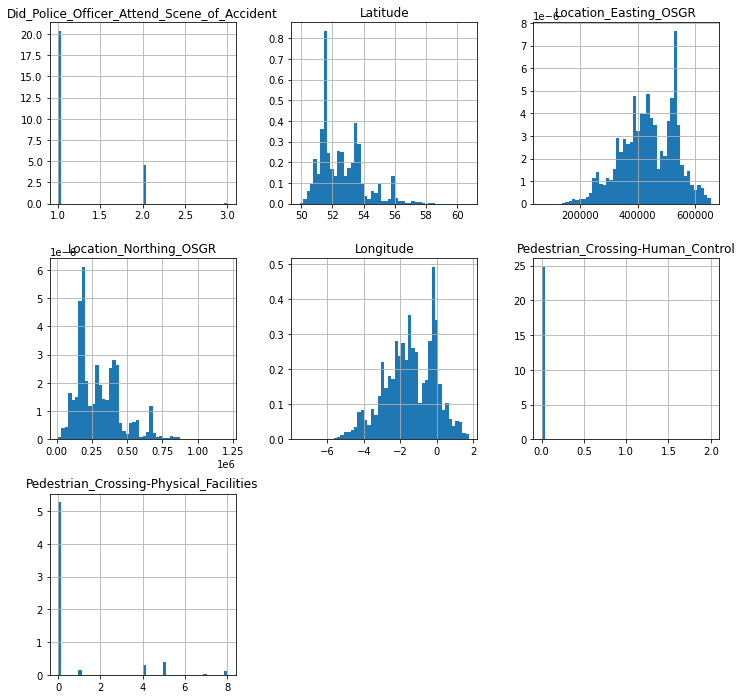

In [23]:
# visualize the distribution 
df.hist(bins=50,density = True, figsize = (12,12))
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

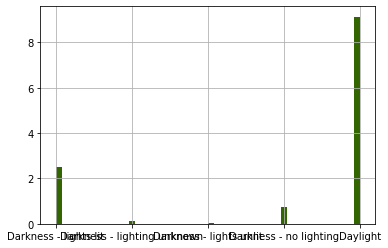

In [24]:
# check for changes in distribution
fig = plt.figure()
ax = fig.add_subplot(111)
# original data
accidentdf['Light_Conditions'].hist(bins=50,ax=ax,density = True, color='red')
# data after cca
df['Light_Conditions'].hist(bins=50,ax=ax,color='green',density=True,alpha=0.8)
plt.show

<AxesSubplot:ylabel='Density'>

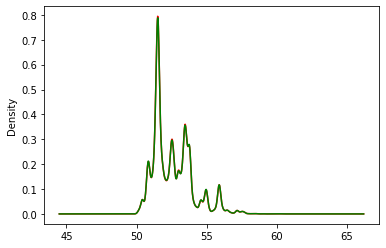

In [25]:
# density plot
fig=plt.figure()
ax = fig.add_subplot(111)
accidentdf['Latitude'].plot.density(color='red')
df['Latitude'].plot.density(color='green')

In [26]:
# percentage change for categorical variables
temp =pd.concat([
    accidentdf['Light_Conditions'].value_counts()/len(accidentdf),
    df['Light_Conditions'].value_counts()/len(df)
],
axis=1)
temp.columns=['original','cca']
temp

,original,cca
Daylight,0.728639,0.730445
Darkness - lights lit,0.198340,0.200098
Darkness - no lighting,0.057979,0.058699
Darkness - lighting unknown,0.008938,0.006638
Darkness - lights unlit,0.004116,0.004120


# **Findings**
**CCA** changes the distribution of:
*  Did_Police_Officer_Attend_Scene_of_Accident',
*  Latitude
*  Light_Conditions
*  Location_Easting_OSGR
*  Location_Northing_OSGR
*  Longitude

# **2. MEAN/MEDIAN IMPUTATION**

In [27]:
accidentdf.isnull().mean()

Accident_Index                                 0.000000
1st_Road_Class                                 0.291432
1st_Road_Number                                0.273558
2nd_Road_Class                                 0.419445
2nd_Road_Number                                0.785196
Accident_Severity                              0.000000
Carriageway_Hazards                            0.000028
Date                                           0.000000
Day_of_Week                                    0.000000
Did_Police_Officer_Attend_Scene_of_Accident    0.000257
Junction_Control                               0.000000
Junction_Detail                                0.000000
Latitude                                       0.000106
Light_Conditions                               0.001987
Local_Authority_(District)                     0.000000
Local_Authority_(Highway)                      0.000000
Location_Easting_OSGR                          0.000106
Location_Northing_OSGR                         0

In [28]:
nullnumcols = [var for var in accidentdf.select_dtypes('number').columns if accidentdf[var].isnull().mean() > 0]
null_num_cols = accidentdf[nullnumcols]
numimpute=null_num_cols.copy()
numimpute.head()
numimpute.isnull().mean()

1st_Road_Number                                0.273558
2nd_Road_Number                                0.785196
Did_Police_Officer_Attend_Scene_of_Accident    0.000257
Latitude                                       0.000106
Location_Easting_OSGR                          0.000106
Location_Northing_OSGR                         0.000106
Longitude                                      0.000107
Pedestrian_Crossing-Human_Control              0.000020
Pedestrian_Crossing-Physical_Facilities        0.000035
dtype: float64

In [29]:
# mean impuation on where cca did not work
mean_median_copy = numimpute.copy()
X = mean_median_copy
y = accidentdf['Accident_Severity']

In [30]:
XTrain,XTest,YTrain,YTest = train_test_split(X,y,test_size=0.2,random_state=22)

In [31]:
XTrain.shape

(838850, 9)

In [32]:
XTrain.isnull().mean()

1st_Road_Number                                0.273666
2nd_Road_Number                                0.785459
Did_Police_Officer_Attend_Scene_of_Accident    0.000267
Latitude                                       0.000103
Location_Easting_OSGR                          0.000103
Location_Northing_OSGR                         0.000103
Longitude                                      0.000104
Pedestrian_Crossing-Human_Control              0.000020
Pedestrian_Crossing-Physical_Facilities        0.000036
dtype: float64

In [33]:
mean_1st = XTrain['1st_Road_Number'].mean()
median_1st = XTrain['1st_Road_Number'].median()

mean_2nd = XTrain['2nd_Road_Number'].mean()
median_2nd = XTrain['2nd_Road_Number'].median()

mean_Did_Police = XTrain['Did_Police_Officer_Attend_Scene_of_Accident'].mean()
median_Did_Police = XTrain['Did_Police_Officer_Attend_Scene_of_Accident'].median()

mean_Latitude = XTrain['Latitude'].mean()
median_Latitude = XTrain['Latitude'].median()

mean_Easting = XTrain['Location_Easting_OSGR'].mean()
median_Easting = XTrain['Location_Easting_OSGR'].median()

mean_Northing = XTrain['Location_Northing_OSGR'].mean()
median_Northing = XTrain['Location_Northing_OSGR'].median()

mean_Longitude = XTrain['Longitude'].mean()
median_Longitude = XTrain['Longitude'].median()

mean_Human = XTrain['Pedestrian_Crossing-Human_Control'].mean()
median_Human = XTrain['Pedestrian_Crossing-Human_Control'].median()

mean_Physical = XTrain['Pedestrian_Crossing-Physical_Facilities'].mean()
median_Physical = XTrain['Pedestrian_Crossing-Physical_Facilities'].median()


In [34]:
XTrain['1st_mean']=XTrain['1st_Road_Number'].fillna(mean_1st)
XTrain['1st_median']=XTrain['1st_Road_Number'].fillna(median_1st)

XTrain['mean_2']=XTrain['2nd_Road_Number'].fillna(mean_2nd)
XTrain['median_2']=XTrain['2nd_Road_Number'].fillna(median_2nd)

XTrain['mean_Did_Police_Attend']=XTrain['Did_Police_Officer_Attend_Scene_of_Accident'].fillna(mean_Did_Police)
XTrain['median_Did_Police_Attend']=XTrain['Did_Police_Officer_Attend_Scene_of_Accident'].fillna(median_Did_Police)

XTrain['mean_Latitude'] = XTrain['Latitude'].fillna(mean_Latitude)
XTrain['median_Latitude'] = XTrain['Latitude'].fillna(median_Latitude)

XTrain['mean_Easting'] = XTrain['Location_Easting_OSGR'].fillna(mean_Easting)
XTrain['median_Easting'] = XTrain['Location_Easting_OSGR'].fillna(median_Easting)

XTrain['mean_Northing'] = XTrain['Location_Northing_OSGR'].fillna(mean_Northing)
XTrain['median_Northing'] = XTrain['Location_Northing_OSGR'].fillna(median_Northing)

XTrain['mean_Longitude'] = XTrain['Longitude'].fillna(mean_Longitude)
XTrain['median_Longitude'] = XTrain['Longitude'].fillna(median_Longitude)

XTrain['mean_Human'] = XTrain['Pedestrian_Crossing-Human_Control'].fillna(mean_Human)
XTrain['median_Human'] = XTrain['Pedestrian_Crossing-Human_Control'].fillna(median_Human)

XTrain['mean_Physical'] = XTrain['Pedestrian_Crossing-Physical_Facilities'].fillna(mean_Physical)
XTrain['median_Physical'] = XTrain['Pedestrian_Crossing-Physical_Facilities'].fillna(median_Physical)


In [35]:
# how will the data look like if it got replaced by the mean?
XTrain.sample(10)

,1st_Road_Number,2nd_Road_Number,Did_Police_Officer_Attend_Scene_of_Accident,Latitude,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,1st_mean,1st_median,mean_2,median_2,mean_Did_Police_Attend,median_Did_Police_Attend,mean_Latitude,median_Latitude,mean_Easting,median_Easting,mean_Northing,median_Northing,mean_Longitude,median_Longitude,mean_Human,median_Human,mean_Physical,median_Physical
835508,29.0,NaN,1.0,52.761245,556680.0,320710.0,0.320573,0.0,0.0,29.000000,29.0,1787.290052,508.0,1.0,1.0,52.761245,52.761245,556680.0,556680.0,320710.0,320710.0,0.320573,0.320573,0.0,0.0,0.0,0.0
528522,259.0,NaN,1.0,50.844272,576470.0,107970.0,0.505276,0.0,0.0,259.000000,259.0,1787.290052,508.0,1.0,1.0,50.844272,50.844272,576470.0,576470.0,107970.0,107970.0,0.505276,0.505276,0.0,0.0,0.0,0.0
381878,NaN,NaN,2.0,55.864354,258620.0,665770.0,-4.260728,0.0,5.0,1392.465359,414.0,1787.290052,508.0,2.0,2.0,55.864354,55.864354,258620.0,258620.0,665770.0,665770.0,-4.260728,-4.260728,0.0,0.0,5.0,5.0
564797,74.0,NaN,2.0,55.836162,267800.0,662340.0,-4.112481,0.0,0.0,74.000000,74.0,1787.290052,508.0,2.0,2.0,55.836162,55.836162,267800.0,267800.0,662340.0,662340.0,-4.112481,-4.112481,0.0,0.0,0.0,0.0
239194,6203.0,NaN,1.0,53.578316,371100.0,409170.0,-2.437963,0.0,0.0,6203.000000,6203.0,1787.290052,508.0,1.0,1.0,53.578316,53.578316,371100.0,371100.0,409170.0,409170.0,-2.437963,-2.437963,0.0,0.0,0.0,0.0
904311,308.0,NaN,2.0,51.480289,526080.0,177270.0,-0.185758,0.0,5.0,308.000000,308.0,1787.290052,508.0,2.0,2.0,51.480289,51.480289,526080.0,526080.0,177270.0,177270.0,-0.185758,-0.185758,0.0,0.0,5.0,5.0
91499,NaN,NaN,1.0,52.305477,404440.0,267490.0,-1.936315,0.0,0.0,1392.465359,414.0,1787.290052,508.0,1.0,1.0,52.305477,52.305477,404440.0,404440.0,267490.0,267490.0,-1.936315,-1.936315,0.0,0.0,0.0,0.0
741140,3216.0,NaN,1.0,51.494521,527940.0,178900.0,-0.158397,0.0,1.0,3216.000000,3216.0,1787.290052,508.0,1.0,1.0,51.494521,51.494521,527940.0,527940.0,178900.0,178900.0,-0.158397,-0.158397,0.0,0.0,1.0,1.0
355541,37.0,NaN,1.0,51.284002,362200.0,154020.0,-2.543409,0.0,0.0,37.000000,37.0,1787.290052,508.0,1.0,1.0,51.284002,51.284002,362200.0,362200.0,154020.0,154020.0,-2.543409,-2.543409,0.0,0.0,0.0,0.0
684022,320.0,NaN,1.0,51.726945,454040.0,203430.0,-1.218993,0.0,0.0,320.000000,320.0,1787.290052,508.0,1.0,1.0,51.726945,51.726945,454040.0,454040.0,203430.0,203430.0,-1.218993,-1.218993,0.0,0.0,0.0,0.0


In [36]:
print("Variance of 1st Road Number is:", XTrain['1st_Road_Number'].var())
print("Variance of the mean of 1st Road Number is:", XTrain['1st_mean'].var())
print("Variance of median of 1st Road Number is:", XTrain['1st_median'].var())

print("Variance of 2nd Road Number is:", XTrain['2nd_Road_Number'].var())
print("Variance of the mean of 2nd Road Number is:", XTrain['mean_2'].var())
print("Variance of median of 2nd Road Number is:", XTrain['median_2'].var())

print("Variance of Did_Police_Officer_Attend_Scene_of_Accident is:", XTrain['Did_Police_Officer_Attend_Scene_of_Accident'].var())
print("Variance of the mean of Did_Police_Officer_Attend_Scene_of_Accident is:", XTrain['mean_Did_Police_Attend'].var())
print("Variance of median of Did_Police_Officer_Attend_Scene_of_Accident is:", XTrain['median_Did_Police_Attend'].var())

print("Variance of Latitude is:", XTrain['Latitude'].var())
print("Variance of the mean of Latitude is:", XTrain['mean_Latitude'].var())
print("Variance of median of Latitude is:", XTrain['median_Latitude'].var())

print("Variance of Location_Easting_OSGR is:", XTrain['Location_Easting_OSGR'].var())
print("Variance of the mean of Location_Easting_OSGR is:", XTrain['mean_Easting'].var())
print("Variance of median of Location_Easting_OSGR is:", XTrain['median_Easting'].var())

print("Variance of Location_Northing_OSGR is:", XTrain['Location_Northing_OSGR'].var())
print("Variance of the mean of Location_Northing_OSGR is:", XTrain['mean_Northing'].var())
print("Variance of median of Location_Northing_OSGR is:", XTrain['median_Northing'].var())

print("Variance of Longitude is:", XTrain['Longitude'].var())
print("Variance of the mean of Longitude is:", XTrain['mean_Longitude'].var())
print("Variance of median of Longitude is:", XTrain['median_Longitude'].var())

print("Variance of Pedestrian_Crossing-Human_Control is:", XTrain['Pedestrian_Crossing-Human_Control'].var())
print("Variance of the mean of Pedestrian_Crossing-Human_Control is:", XTrain['mean_Human'].var())
print("Variance of median of Pedestrian_Crossing-Human_Control is:", XTrain['median_Human'].var())

print("Variance of Pedestrian_Crossing-Physical_Facilities is:", XTrain['Pedestrian_Crossing-Physical_Facilities'].var())
print("Variance of the mean of Pedestrian_Crossing-Physical_Facilities is:", XTrain['mean_Physical'].var())
print("Variance of median of Pedestrian_Crossing-Physical_Facilities is:", XTrain['median_Physical'].var())

Variance of 1st Road Number is: 4089391.5062238467
Variance of the mean of 1st Road Number is: 2970261.4111456177
Variance of median of 1st Road Number is: 3160565.87296978
Variance of 2nd Road Number is: 5510850.615364528
Variance of the mean of 2nd Road Number is: 1182300.09536318
Variance of median of 2nd Road Number is: 1458086.5162933029
Variance of Did_Police_Officer_Attend_Scene_of_Accident is: 0.16482459275189498
Variance of the mean of Did_Police_Officer_Attend_Scene_of_Accident is: 0.16478057921814046
Variance of median of Did_Police_Officer_Attend_Scene_of_Accident is: 0.16479108479395374
Variance of Latitude is: 2.0278601351628884
Variance of the mean of Latitude is: 2.0276522360396565
Variance of median of Latitude is: 2.027657597034787
Variance of Location_Easting_OSGR is: 8984575866.148138
Variance of the mean of Location_Easting_OSGR is: 8983654754.572048
Variance of median of Location_Easting_OSGR is: 8983654794.045706
Variance of Location_Northing_OSGR is: 25004247265

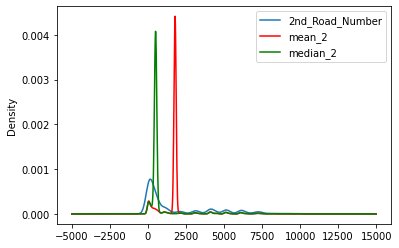

In [37]:
# to check if the distribution changed
fig = plt.figure()
ax = fig.add_subplot(111)
XTrain["2nd_Road_Number"].plot(kind='kde',ax=ax)
XTrain['mean_2'].plot(kind='kde',ax=ax,color = 'red')
XTrain['median_2'].plot(kind='kde',ax=ax,color='green')

lines,labels = ax.get_legend_handles_labels()
ax.legend(lines,labels,loc='best')
plt.show()

In [38]:
# ideally we would want the variance the variance not disturbed
# more change , change in covariance with other variables
XTrain.cov()

,1st_Road_Number,2nd_Road_Number,Did_Police_Officer_Attend_Scene_of_Accident,Latitude,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,1st_mean,1st_median,mean_2,median_2,mean_Did_Police_Attend,median_Did_Police_Attend,mean_Latitude,median_Latitude,mean_Easting,median_Easting,mean_Northing,median_Northing,mean_Longitude,median_Longitude,mean_Human,median_Human,mean_Physical,median_Physical
1st_Road_Number,4.089392e+06,1.728589e+06,27.809355,192.383572,-2.868238e+07,2.099005e+07,-414.523170,1.333943,39.495018,4.089392e+06,4.089392e+06,4.621672e+05,4.681331e+05,27.802011,27.815470,192.366975,192.363020,-2.867996e+07,-2.867997e+07,2.098824e+07,2.098780e+07,-414.488213,-414.487890,1.333929,1.333868,39.495253,39.506366
2nd_Road_Number,1.728589e+06,5.510851e+06,-0.115844,55.117673,-2.275595e+07,5.804480e+06,-329.704033,0.470284,3.817677,1.564682e+06,1.572914e+06,5.510851e+06,5.510851e+06,-0.115568,-0.114251,55.115516,55.115910,-2.275503e+07,-2.275503e+07,5.804252e+06,5.804296e+06,-329.690789,-329.690821,0.470268,0.470181,3.812911,3.807215
Did_Police_Officer_Attend_Scene_of_Accident,2.780935e+01,-1.158441e-01,0.164825,-0.006746,1.094239e+02,-7.624622e+02,0.001908,0.000515,0.005598,2.019892e+01,8.772453e+00,-2.480059e-02,1.075976e+01,0.164825,0.164825,-0.006745,-0.006747,1.094127e+02,1.094061e+02,-7.623837e+02,-7.626531e+02,0.001908,0.001908,0.000515,0.000515,0.005597,0.005597
Latitude,1.923836e+02,5.511767e+01,-0.006746,2.027860,-5.322398e+04,2.251717e+05,-0.802298,0.007800,0.007275,1.397369e+02,1.210764e+02,1.182572e+01,9.680454e+00,-0.006744,-0.006781,2.027860,2.027860,-5.322398e+04,-5.322398e+04,2.251717e+05,2.251717e+05,-0.802297,-0.802297,0.007799,0.007799,0.007274,0.007250
Location_Easting_OSGR,-2.868238e+07,-2.275595e+07,109.423881,-53223.976731,8.984576e+09,-5.880070e+09,131840.685128,-307.040077,8298.731758,-2.083335e+07,-1.585026e+07,-4.882375e+06,-3.815033e+05,109.394689,108.809490,-53223.976731,-53223.976731,8.984576e+09,8.984576e+09,-5.880070e+09,-5.880070e+09,131840.527943,131840.528655,-307.033860,-307.022017,8298.444866,8299.858619
Location_Northing_OSGR,2.099005e+07,5.804480e+06,-762.462158,225171.688676,-5.880070e+09,2.500425e+10,-88669.386103,867.238185,780.274386,1.524602e+07,1.318579e+07,1.245374e+06,9.738476e+05,-762.258312,-766.406600,225171.688676,225171.688676,-5.880070e+09,-5.880070e+09,2.500425e+10,2.500425e+10,-88669.280389,-88669.284431,867.220621,867.196360,780.247343,777.556030
Longitude,-4.145232e+02,-3.297040e+02,0.001908,-0.802298,1.318407e+05,-8.866939e+04,1.937083,-0.004733,0.118820,-3.010878e+02,-2.278539e+02,-7.073933e+01,-3.813886e+00,0.001908,0.001897,-0.802298,-0.802298,1.318407e+05,1.318407e+05,-8.866939e+04,-8.866939e+04,1.937083,1.937083,-0.004732,-0.004732,0.118816,0.118837
Pedestrian_Crossing-Human_Control,1.333943e+00,4.702840e-01,0.000515,0.007800,-3.070401e+02,8.672382e+02,-0.004733,0.016107,0.022404,9.688967e-01,6.021349e-01,1.008936e-01,4.117704e-01,0.000515,0.000515,0.007799,0.007798,-3.070086e+02,-3.070117e+02,8.671493e+02,8.670228e+02,-0.004732,-0.004732,0.016107,0.016107,0.022403,0.022402
Pedestrian_Crossing-Physical_Facilities,3.949502e+01,3.817677e+00,0.005598,0.007275,8.298732e+03,7.802744e+02,0.118820,0.022404,3.064647,2.868774e+01,9.529959e+01,8.180527e-01,1.528323e+02,0.005596,0.005620,0.007274,0.007278,8.297891e+03,8.297901e+03,7.801953e+02,7.806112e+02,0.118808,0.118808,0.022403,0.022403,3.064647,3.064647
1st_mean,4.089392e+06,1.564682e+06,20.198921,139.736874,-2.083335e+07,1.524602e+07,-301.087837,0.968897,28.687745,2.970261e+06,2.970261e+06,3.356874e+05,3.400206e+05,20.193528,20.203303,139.722548,139.719676,-2.083121e+07,-2.083122e+07,1.524446e+07,1.524414e+07,-301.056610,-301.056376,0.968877,0.968833,28.686719,28.694791


In [39]:
XTrain.corr()

,1st_Road_Number,2nd_Road_Number,Did_Police_Officer_Attend_Scene_of_Accident,Latitude,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,1st_mean,1st_median,mean_2,median_2,mean_Did_Police_Attend,median_Did_Police_Attend,mean_Latitude,median_Latitude,mean_Easting,median_Easting,mean_Northing,median_Northing,mean_Longitude,median_Longitude,mean_Human,median_Human,mean_Physical,median_Physical
1st_Road_Number,1.000000,0.350609,0.034952,0.068351,-0.152637,0.067169,-0.150266,0.005313,0.010567,1.000000,1.000000,0.186499,0.171269,0.034947,0.034963,0.068347,0.068346,-0.152629,-0.152629,0.067166,0.067164,-0.150258,-0.150258,0.005313,0.005313,0.010567,0.010570
2nd_Road_Number,0.350609,1.000000,-0.000114,0.018447,-0.121850,0.017505,-0.120353,0.001465,0.000726,0.336788,0.334938,1.000000,1.000000,-0.000114,-0.000112,0.018446,0.018446,-0.121846,-0.121846,0.017504,0.017504,-0.120348,-0.120349,0.001465,0.001464,0.000725,0.000724
Did_Police_Officer_Attend_Scene_of_Accident,0.034952,-0.000114,1.000000,-0.011668,0.002843,-0.011877,0.003378,0.009992,0.007875,0.028867,0.012154,-0.000056,0.021947,1.000000,1.000000,-0.011667,-0.011671,0.002843,0.002843,-0.011876,-0.011880,0.003377,0.003378,0.009992,0.009991,0.007875,0.007874
Latitude,0.068351,0.018447,-0.011668,1.000000,-0.394312,0.999972,-0.404802,0.043168,0.002918,0.056937,0.047826,0.007637,0.005630,-0.011667,-0.011731,1.000000,1.000000,-0.394312,-0.394312,0.999972,0.999972,-0.404802,-0.404802,0.043168,0.043166,0.002918,0.002908
Location_Easting_OSGR,-0.152637,-0.121850,0.002843,-0.394312,1.000000,-0.392308,0.999370,-0.025530,0.050012,-0.127530,-0.094060,-0.047371,-0.003333,0.002843,0.002828,-0.394312,-0.394312,1.000000,1.000000,-0.392308,-0.392308,0.999370,0.999370,-0.025530,-0.025529,0.050011,0.050019
Location_Northing_OSGR,0.067169,0.017505,-0.011877,0.999972,-0.392308,1.000000,-0.402896,0.043226,0.002819,0.055944,0.046905,0.007243,0.005100,-0.011876,-0.011940,0.999972,0.999972,-0.392308,-0.392308,1.000000,1.000000,-0.402896,-0.402896,0.043226,0.043224,0.002819,0.002809
Longitude,-0.150266,-0.120353,0.003378,-0.404802,0.999370,-0.402896,1.000000,-0.026800,0.048767,-0.125523,-0.092088,-0.046743,-0.002269,0.003377,0.003358,-0.404802,-0.404802,0.999370,0.999370,-0.402896,-0.402896,1.000000,1.000000,-0.026800,-0.026799,0.048766,0.048775
Pedestrian_Crossing-Human_Control,0.005313,0.001465,0.009992,0.043168,-0.025530,0.043226,-0.026800,1.000000,0.100840,0.004430,0.002669,0.000731,0.002687,0.009991,0.009991,0.043154,0.043147,-0.025522,-0.025522,0.043212,0.043205,-0.026791,-0.026790,1.000000,1.000000,0.100836,0.100833
Pedestrian_Crossing-Physical_Facilities,0.010567,0.000726,0.007875,0.002918,0.050012,0.002819,0.048767,0.100840,1.000000,0.009508,0.030621,0.000430,0.072299,0.007875,0.007909,0.002918,0.002919,0.050009,0.050009,0.002819,0.002820,0.048765,0.048764,0.100839,0.100838,1.000000,1.000000
1st_mean,1.000000,0.336788,0.028867,0.056937,-0.127530,0.055944,-0.125523,0.004430,0.009508,1.000000,0.969427,0.179132,0.163387,0.028864,0.028877,0.056934,0.056933,-0.127524,-0.127524,0.055941,0.055940,-0.125516,-0.125516,0.004430,0.004429,0.009508,0.009511


# FINDINGS
* Mean/Median imputation can work on all numerical variables except 1st_Road_Number.
* mean/median imputation changes the distribution of 1st_Road_Number, 2nd_Road_Number and data is skewed.
* The distribution is symmetric; mean = median.
* Data is less/not skewed for all other columns.
* Mean imputation changes the behaviour of:
    *  Pedestrian_Crossing-Human_Control
    *  Did_Police_Officer_Attend_Scene_of_Accident
    *  Pedestrian_Crossing-Physical_Facilities     

<AxesSubplot:>

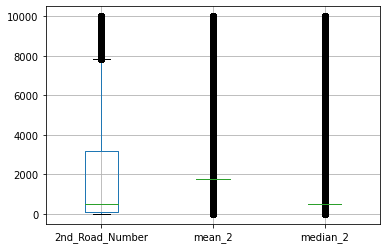

In [40]:
# box plot to check for outliers
XTrain[['2nd_Road_Number','mean_2','median_2']].boxplot()


In [41]:
XTrain.isnull().mean()

1st_Road_Number                                0.273666
2nd_Road_Number                                0.785459
Did_Police_Officer_Attend_Scene_of_Accident    0.000267
Latitude                                       0.000103
Location_Easting_OSGR                          0.000103
Location_Northing_OSGR                         0.000103
Longitude                                      0.000104
Pedestrian_Crossing-Human_Control              0.000020
Pedestrian_Crossing-Physical_Facilities        0.000036
1st_mean                                       0.000000
1st_median                                     0.000000
mean_2                                         0.000000
median_2                                       0.000000
mean_Did_Police_Attend                         0.000000
median_Did_Police_Attend                       0.000000
mean_Latitude                                  0.000000
median_Latitude                                0.000000
mean_Easting                                   0

# **3. ARBITRARY VALUE IMPUTATION**

In [42]:
arbitrary_copy = mean_median_copy.copy()
arbitrary_copy.shape
X = arbitrary_copy
y = accidentdf["Accident_Severity"]

In [43]:
XTrain,XTest,YTrain,YTest = train_test_split(X,y,test_size=0.2,random_state=22)

In [44]:
XTrain.shape, XTest.shape, YTrain.shape, YTest.shape

((838850, 9), (209713, 9), (838850,), (209713,))

In [45]:
XTrain.isnull().mean()

1st_Road_Number                                0.273666
2nd_Road_Number                                0.785459
Did_Police_Officer_Attend_Scene_of_Accident    0.000267
Latitude                                       0.000103
Location_Easting_OSGR                          0.000103
Location_Northing_OSGR                         0.000103
Longitude                                      0.000104
Pedestrian_Crossing-Human_Control              0.000020
Pedestrian_Crossing-Physical_Facilities        0.000036
dtype: float64

In [46]:
XTrain.describe()

,1st_Road_Number,2nd_Road_Number,Did_Police_Officer_Attend_Scene_of_Accident,Latitude,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities
count,609285.000000,179968.000000,838626.000000,838764.000000,838764.000000,8.387640e+05,838763.000000,838833.000000,838820.000000
mean,1392.465359,1787.290052,1.198374,52.572681,438370.538345,2.982811e+05,-1.453595,0.009325,0.680064
std,2022.224396,2347.520099,0.405986,1.424030,94787.002622,1.581273e+05,1.391791,0.126913,1.750613
min,1.000000,1.000000,1.000000,49.914430,65860.000000,1.052000e+04,-7.498973,0.000000,0.000000
25%,61.000000,127.000000,1.000000,51.492541,375250.000000,1.784800e+05,-2.370208,0.000000,0.000000
50%,414.000000,508.000000,1.000000,52.343996,437750.000000,2.730100e+05,-1.434928,0.000000,0.000000
75%,1514.000000,3205.000000,1.000000,53.463033,521190.000000,3.964700e+05,-0.243959,0.000000,0.000000
max,9999.000000,9999.000000,3.000000,60.757544,655370.000000,1.208800e+06,1.759398,2.000000,8.000000


In [47]:
# filling in with arbitrary values
# pick any random number greater than max value, and less than min value
# which one works better
XTrain['1st_max']=XTrain['1st_Road_Number'].fillna(50000)
XTrain['1st_min']=XTrain['1st_Road_Number'].fillna(-100)

XTrain['2nd_max']=XTrain['2nd_Road_Number'].fillna(23468)
XTrain['2nd_min']=XTrain['2nd_Road_Number'].fillna(-1)

XTrain['Did_Police_Attend_max']=XTrain['Did_Police_Officer_Attend_Scene_of_Accident'].fillna(4)
XTrain['Did_Police_Attend_min']=XTrain['Did_Police_Officer_Attend_Scene_of_Accident'].fillna(0)

XTrain['Latitude_max'] = XTrain['Latitude'].fillna(700)
XTrain['Latitude_min'] = XTrain['Latitude'].fillna(12)

XTrain['Easting_max'] = XTrain['Location_Easting_OSGR'].fillna(1000000)
XTrain['Easting_min'] = XTrain['Location_Easting_OSGR'].fillna(10000)

XTrain['Northing_max'] = XTrain['Location_Northing_OSGR'].fillna(2.6)
XTrain['Northing_min'] = XTrain['Location_Northing_OSGR'].fillna(0.2)

XTrain['Longitude_max'] = XTrain['Longitude'].fillna(20)
XTrain['Longitude_min'] = XTrain['Longitude'].fillna(-50)

XTrain['Human_max'] = XTrain['Pedestrian_Crossing-Human_Control'].fillna(10)
XTrain['Human_min'] = XTrain['Pedestrian_Crossing-Human_Control'].fillna(-1)

XTrain['Physical_max'] = XTrain['Pedestrian_Crossing-Physical_Facilities'].fillna(10)
XTrain['Physical_min'] = XTrain['Pedestrian_Crossing-Physical_Facilities'].fillna(-1)


In [48]:
XTrain.sample(5)

,1st_Road_Number,2nd_Road_Number,Did_Police_Officer_Attend_Scene_of_Accident,Latitude,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,1st_max,1st_min,2nd_max,2nd_min,Did_Police_Attend_max,Did_Police_Attend_min,Latitude_max,Latitude_min,Easting_max,Easting_min,Northing_max,Northing_min,Longitude_max,Longitude_min,Human_max,Human_min,Physical_max,Physical_min
699400,427.0,NaN,3.0,51.368734,638450.0,168870.0,1.424431,0.0,0.0,427.0,427.0,23468.0,-1.0,3.0,3.0,51.368734,51.368734,638450.0,638450.0,168870.0,168870.0,1.424431,1.424431,0.0,0.0,0.0,0.0
749532,203.0,NaN,2.0,51.468812,530720.0,176110.0,-0.119405,0.0,5.0,203.0,203.0,23468.0,-1.0,2.0,2.0,51.468812,51.468812,530720.0,530720.0,176110.0,176110.0,-0.119405,-0.119405,0.0,0.0,5.0,5.0
633803,NaN,NaN,1.0,54.020396,480360.0,458960.0,-0.774932,0.0,0.0,50000.0,-100.0,23468.0,-1.0,1.0,1.0,54.020396,54.020396,480360.0,480360.0,458960.0,458960.0,-0.774932,-0.774932,0.0,0.0,0.0,0.0
409579,503.0,NaN,2.0,51.587901,534480.0,189460.0,-0.060211,0.0,0.0,503.0,503.0,23468.0,-1.0,2.0,2.0,51.587901,51.587901,534480.0,534480.0,189460.0,189460.0,-0.060211,-0.060211,0.0,0.0,0.0,0.0
696967,NaN,NaN,1.0,51.374666,576740.0,167020.0,0.538015,0.0,0.0,50000.0,-100.0,23468.0,-1.0,1.0,1.0,51.374666,51.374666,576740.0,576740.0,167020.0,167020.0,0.538015,0.538015,0.0,0.0,0.0,0.0


In [49]:
print("Variance of 1st Road Number is:", XTrain['1st_Road_Number'].var())
print("Variance of the max of 1st Road Number is:", XTrain['1st_max'].var())
print("Variance of min of 1st Road Number is:", XTrain['1st_min'].var())

print("Variance of 2nd Road Number is:", XTrain['2nd_Road_Number'].var())
print("Variance of the max of 2nd Road Number is:", XTrain['2nd_max'].var())
print("Variance of min of 2nd Road Number is:", XTrain['2nd_min'].var())

print("Variance of Did_Police_Officer_Attend_Scene_of_Accident is:", XTrain['Did_Police_Officer_Attend_Scene_of_Accident'].var())
print("Variance of the max of Did_Police_Officer_Attend_Scene_of_Accident is:", XTrain['Did_Police_Attend_max'].var())
print("Variance of min of Did_Police_Officer_Attend_Scene_of_Accident is:", XTrain['Did_Police_Attend_max'].var())

print("Variance of Latitude is:", XTrain['Latitude'].var())
print("Variance of the max of Latitude is:", XTrain['Latitude_max'].var())
print("Variance of min of Latitude is:", XTrain['Latitude_min'].var())

print("Variance of Location_Easting_OSGR is:", XTrain['Location_Easting_OSGR'].var())
print("Variance of the max of Location_Easting_OSGR is:", XTrain['Easting_max'].var())
print("Variance of min of Location_Easting_OSGR is:", XTrain['Easting_min'].var())

print("Variance of Location_Northing_OSGR is:", XTrain['Location_Northing_OSGR'].var())
print("Variance of the max of Location_Northing_OSGR is:", XTrain['Northing_max'].var())
print("Variance of min of Location_Northing_OSGR is:", XTrain['Northing_min'].var())

print("Variance of Longitude is:", XTrain['Longitude'].var())
print("Variance of the max of Longitude is:", XTrain['Longitude_max'].var())
print("Variance of min of Longitude is:", XTrain['Longitude_min'].var())

print("Variance of Pedestrian_Crossing-Human_Control is:", XTrain['Pedestrian_Crossing-Human_Control'].var())
print("Variance of the max of Pedestrian_Crossing-Human_Control is:", XTrain['Human_max'].var())
print("Variance of min of Pedestrian_Crossing-Human_Control is:", XTrain['Human_min'].var())

print("Variance of Pedestrian_Crossing-Physical_Facilities is:", XTrain['Pedestrian_Crossing-Physical_Facilities'].var())
print("Variance of the max of Pedestrian_Crossing-Physical_Facilities is:", XTrain['Physical_max'].var())
print("Variance of min of Pedestrian_Crossing-Physical_Facilities is:", XTrain['Physical_min'].var())

Variance of 1st Road Number is: 4089391.5062238467
Variance of the max of 1st Road Number is: 472610446.2521838
Variance of min of 1st Road Number is: 3413019.5780524286
Variance of 2nd Road Number is: 5510850.615364528
Variance of the max of 2nd Road Number is: 80392631.84857725
Variance of min of 2nd Road Number is: 1721203.2856453871
Variance of Did_Police_Officer_Attend_Scene_of_Accident is: 0.16482459275189498
Variance of the max of Did_Police_Officer_Attend_Scene_of_Accident is: 0.16687598630949418
Variance of min of Did_Police_Officer_Attend_Scene_of_Accident is: 0.16687598630949418
Variance of Latitude is: 2.0278601351628884
Variance of the max of Latitude is: 44.996348379553766
Variance of min of Latitude is: 2.1963998130602738
Variance of Location_Easting_OSGR is: 8984575866.148138
Variance of the max of Location_Easting_OSGR is: 9015989533.556536
Variance of min of Location_Easting_OSGR is: 9002465643.609356
Variance of Location_Northing_OSGR is: 25004247265.733852
Variance 

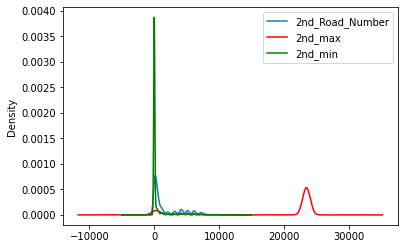

In [50]:
# plot the distribution
# to check if the distribution changed
fig = plt.figure()
ax = fig.add_subplot(111)
XTrain["2nd_Road_Number"].plot(kind='kde',ax=ax)
XTrain['2nd_max'].plot(kind='kde',ax=ax,color = 'red')
XTrain['2nd_min'].plot(kind='kde',ax=ax,color='green')

lines,labels = ax.get_legend_handles_labels()
ax.legend(lines,labels,loc='best')
plt.show()

In [51]:
XTrain.describe()

,1st_Road_Number,2nd_Road_Number,Did_Police_Officer_Attend_Scene_of_Accident,Latitude,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,1st_max,1st_min,2nd_max,2nd_min,Did_Police_Attend_max,Did_Police_Attend_min,Latitude_max,Latitude_min,Easting_max,Easting_min,Northing_max,Northing_min,Longitude_max,Longitude_min,Human_max,Human_min,Physical_max,Physical_min
count,609285.000000,179968.000000,838626.000000,838764.000000,838764.000000,8.387640e+05,838763.000000,838833.000000,838820.000000,838850.000000,838850.000000,838850.000000,838850.000000,838850.000000,838850.000000,838850.000000,838850.000000,838850.000000,838850.000000,8.388500e+05,8.388500e+05,838850.000000,838850.000000,838850.000000,838850.000000,838850.000000,838850.000000
mean,1392.465359,1787.290052,1.198374,52.572681,438370.538345,2.982811e+05,-1.453595,0.009325,0.680064,14694.710921,984.027843,18816.591515,382.662137,1.199123,1.198054,52.639056,52.568521,438428.117332,438326.621236,2.982506e+05,2.982506e+05,-1.451370,-1.458630,0.009527,0.009304,0.680397,0.680004
std,2022.224396,2347.520099,0.405986,1.424030,94787.002622,1.581273e+05,1.391791,0.126913,1.750613,21739.605476,1847.435947,8966.193833,1311.946373,0.408505,0.406404,6.707932,1.482026,94952.564650,94881.323998,1.581480e+05,1.581480e+05,1.408763,1.476917,0.134646,0.126993,1.751469,1.750611
min,1.000000,1.000000,1.000000,49.914430,65860.000000,1.052000e+04,-7.498973,0.000000,0.000000,1.000000,-100.000000,1.000000,-1.000000,1.000000,0.000000,49.914430,12.000000,65860.000000,10000.000000,2.600000e+00,2.000000e-01,-7.498973,-50.000000,0.000000,-1.000000,0.000000,-1.000000
25%,61.000000,127.000000,1.000000,51.492541,375250.000000,1.784800e+05,-2.370208,0.000000,0.000000,169.000000,-100.000000,23468.000000,-1.000000,1.000000,1.000000,51.492563,51.492492,375260.000000,375230.000000,1.784700e+05,1.784700e+05,-2.369982,-2.370757,0.000000,0.000000,0.000000,0.000000
50%,414.000000,508.000000,1.000000,52.343996,437750.000000,2.730100e+05,-1.434928,0.000000,0.000000,1009.000000,125.000000,23468.000000,-1.000000,1.000000,1.000000,52.344290,52.343686,437760.000000,437740.000000,2.729800e+05,2.729800e+05,-1.434786,-1.435101,0.000000,0.000000,0.000000,0.000000
75%,1514.000000,3205.000000,1.000000,53.463033,521190.000000,3.964700e+05,-0.243959,0.000000,0.000000,50000.000000,706.000000,23468.000000,-1.000000,1.000000,1.000000,53.463315,53.462953,521210.000000,521190.000000,3.964600e+05,3.964600e+05,-0.243831,-0.244044,0.000000,0.000000,0.000000,0.000000
max,9999.000000,9999.000000,3.000000,60.757544,655370.000000,1.208800e+06,1.759398,2.000000,8.000000,50000.000000,9999.000000,23468.000000,9999.000000,4.000000,3.000000,700.000000,60.757544,1000000.000000,655370.000000,1.208800e+06,1.208800e+06,20.000000,1.759398,10.000000,2.000000,10.000000,8.000000


# **FINDINGS**
Using arbitrary value imputation in both the 1st road and 2nd road of the columns does not distort the distrubution of our data.

# **4. RANDOM VALUE IMPUTATION**

In [52]:
random_copy = arbitrary_copy.copy()
random_copy.isnull().mean()

1st_Road_Number                                0.273558
2nd_Road_Number                                0.785196
Did_Police_Officer_Attend_Scene_of_Accident    0.000257
Latitude                                       0.000106
Location_Easting_OSGR                          0.000106
Location_Northing_OSGR                         0.000106
Longitude                                      0.000107
Pedestrian_Crossing-Human_Control              0.000020
Pedestrian_Crossing-Physical_Facilities        0.000035
dtype: float64

In [53]:
X = random_copy
y = accidentdf['Accident_Severity']

In [54]:
XTrain, XTest, YTrain, YTest = train_test_split(X, y, test_size=0.2,random_state = 22)

In [55]:
XTrainoriginal = XTrain.copy()
XTestoriginal = XTest.copy()

In [56]:
XTrain.isnull().mean()

1st_Road_Number                                0.273666
2nd_Road_Number                                0.785459
Did_Police_Officer_Attend_Scene_of_Accident    0.000267
Latitude                                       0.000103
Location_Easting_OSGR                          0.000103
Location_Northing_OSGR                         0.000103
Longitude                                      0.000104
Pedestrian_Crossing-Human_Control              0.000020
Pedestrian_Crossing-Physical_Facilities        0.000036
dtype: float64

In [57]:
# create a separate column
XTrain_na = XTrain['2nd_Road_Number'].isnull().sum()

In [58]:
XTrain_na

658882

In [59]:
# pick one column first
random_sample = XTrain['2nd_Road_Number'].dropna().sample((XTrain_na), random_state=22, replace=True)
# fill in with randomly picked Xtrain_na
# what is the index of all the missing values, then put the missing values in the index
random_sample.index = XTrain[XTrain['2nd_Road_Number'].isnull()].index

In [60]:
# now replace the missing values in the original dataset with the randomly extracted values
XTrain.loc[XTrain['2nd_Road_Number'].isnull(),'2nd_Road_Number']=random_sample


In [61]:
# now, how many values are in 2nd road number?
XTrain['2nd_Road_Number'].isnull().sum()

0

In [62]:
XTrain.sample(5)

,1st_Road_Number,2nd_Road_Number,Did_Police_Officer_Attend_Scene_of_Accident,Latitude,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities
141082,27.0,3024.0,1.0,50.897329,447980.0,111100.0,-1.319126,0.0,0.0
232160,NaN,3108.0,1.0,53.503706,335620.0,401220.0,-2.972129,0.0,0.0
102434,NaN,5.0,1.0,52.990524,450140.0,343950.0,-1.254493,0.0,0.0
767615,NaN,406.0,1.0,53.712942,347810.0,424350.0,-2.792243,0.0,0.0
334218,33.0,41.0,1.0,51.301039,466870.0,156210.0,-1.042204,0.0,0.0


In [63]:
# list of columns in XTrain
mylist = XTrain.columns.values.tolist()
print(len(mylist))

9


In [64]:
for var in mylist:
    random_sample_train = XTrain[var].dropna().sample(XTrain[var].isnull().sum(), random_state=22)
#     repeat for the test set
    random_sample_test = XTrain[var].dropna().sample(XTest[var].isnull().sum(), random_state=22)
# reindex the randomly sampled values
    random_sample_train.index = XTrain[XTrain[var].isnull()].index
    random_sample_test.index = XTest[XTest[var].isnull()].index
# replace null values
    XTrain.loc[XTrain[var].isnull(),var]=random_sample_train
    XTest.loc[XTest[var].isnull(),var]=random_sample_test

In [65]:
XTrain.isnull().mean()

1st_Road_Number                                0.0
2nd_Road_Number                                0.0
Did_Police_Officer_Attend_Scene_of_Accident    0.0
Latitude                                       0.0
Location_Easting_OSGR                          0.0
Location_Northing_OSGR                         0.0
Longitude                                      0.0
Pedestrian_Crossing-Human_Control              0.0
Pedestrian_Crossing-Physical_Facilities        0.0
dtype: float64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


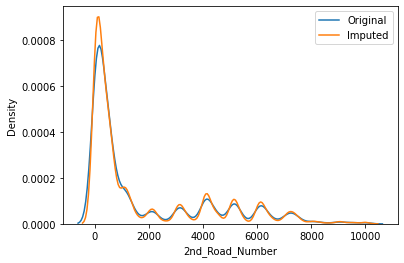

In [66]:
# plot of the original one vs plot of the new one
sns.distplot(XTrainoriginal["2nd_Road_Number"], label = "Original",hist=False)
sns.distplot(XTrain["2nd_Road_Number"],label='Imputed',hist=False)
plt.legend()
plt.show()

In [67]:
# look at the variance
print("Original variable variance is", XTrainoriginal['2nd_Road_Number'].var())
print("Variance of imputed is:", XTrain['2nd_Road_Number'].var())

Original variable variance is 5510850.615364528
Variance of imputed is: 5499226.181964582


In [68]:
# covariance
XTrainoriginal.cov()

,1st_Road_Number,2nd_Road_Number,Did_Police_Officer_Attend_Scene_of_Accident,Latitude,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities
1st_Road_Number,4.089392e+06,1.728589e+06,27.809355,192.383572,-2.868238e+07,2.099005e+07,-414.523170,1.333943,39.495018
2nd_Road_Number,1.728589e+06,5.510851e+06,-0.115844,55.117673,-2.275595e+07,5.804480e+06,-329.704033,0.470284,3.817677
Did_Police_Officer_Attend_Scene_of_Accident,2.780935e+01,-1.158441e-01,0.164825,-0.006746,1.094239e+02,-7.624622e+02,0.001908,0.000515,0.005598
Latitude,1.923836e+02,5.511767e+01,-0.006746,2.027860,-5.322398e+04,2.251717e+05,-0.802298,0.007800,0.007275
Location_Easting_OSGR,-2.868238e+07,-2.275595e+07,109.423881,-53223.976731,8.984576e+09,-5.880070e+09,131840.685128,-307.040077,8298.731758
Location_Northing_OSGR,2.099005e+07,5.804480e+06,-762.462158,225171.688676,-5.880070e+09,2.500425e+10,-88669.386103,867.238185,780.274386
Longitude,-4.145232e+02,-3.297040e+02,0.001908,-0.802298,1.318407e+05,-8.866939e+04,1.937083,-0.004733,0.118820
Pedestrian_Crossing-Human_Control,1.333943e+00,4.702840e-01,0.000515,0.007800,-3.070401e+02,8.672382e+02,-0.004733,0.016107,0.022404
Pedestrian_Crossing-Physical_Facilities,3.949502e+01,3.817677e+00,0.005598,0.007275,8.298732e+03,7.802744e+02,0.118820,0.022404,3.064647


In [69]:
XTrain.cov()

,1st_Road_Number,2nd_Road_Number,Did_Police_Officer_Attend_Scene_of_Accident,Latitude,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities
1st_Road_Number,4.089517e+06,3.323379e+05,19.808210,138.131542,-2.079117e+07,1.506628e+07,-300.380135,1.082432,27.483608
2nd_Road_Number,3.323379e+05,5.499226e+06,-0.570389,3.395521,-4.393112e+06,3.093875e+05,-63.406647,0.082292,5.708726
Did_Police_Officer_Attend_Scene_of_Accident,1.980821e+01,-5.703890e-01,0.164821,-0.006731,1.101831e+02,-7.608522e+02,0.001909,0.000514,0.005600
Latitude,1.381315e+02,3.395521e+00,-0.006731,2.027819,-5.322292e+04,2.251671e+05,-0.802263,0.007801,0.007266
Location_Easting_OSGR,-2.079117e+07,-4.393112e+06,110.183120,-53222.921825,8.984471e+09,-5.879949e+09,131830.205533,-307.367664,8297.291927
Location_Northing_OSGR,1.506628e+07,3.093875e+05,-760.852185,225167.075737,-5.879949e+09,2.500373e+10,-88665.475504,867.432877,779.371787
Longitude,-3.003801e+02,-6.340665e+01,0.001909,-0.802263,1.318302e+05,-8.866548e+04,1.937099,-0.004730,0.118824
Pedestrian_Crossing-Human_Control,1.082432e+00,8.229157e-02,0.000514,0.007801,-3.073677e+02,8.674329e+02,-0.004730,0.016107,0.022402
Pedestrian_Crossing-Physical_Facilities,2.748361e+01,5.708726e+00,0.005600,0.007266,8.297292e+03,7.793718e+02,0.118824,0.022402,3.064626


In [70]:
XTrainoriginal.corr()

,1st_Road_Number,2nd_Road_Number,Did_Police_Officer_Attend_Scene_of_Accident,Latitude,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities
1st_Road_Number,1.000000,0.350609,0.034952,0.068351,-0.152637,0.067169,-0.150266,0.005313,0.010567
2nd_Road_Number,0.350609,1.000000,-0.000114,0.018447,-0.121850,0.017505,-0.120353,0.001465,0.000726
Did_Police_Officer_Attend_Scene_of_Accident,0.034952,-0.000114,1.000000,-0.011668,0.002843,-0.011877,0.003378,0.009992,0.007875
Latitude,0.068351,0.018447,-0.011668,1.000000,-0.394312,0.999972,-0.404802,0.043168,0.002918
Location_Easting_OSGR,-0.152637,-0.121850,0.002843,-0.394312,1.000000,-0.392308,0.999370,-0.025530,0.050012
Location_Northing_OSGR,0.067169,0.017505,-0.011877,0.999972,-0.392308,1.000000,-0.402896,0.043226,0.002819
Longitude,-0.150266,-0.120353,0.003378,-0.404802,0.999370,-0.402896,1.000000,-0.026800,0.048767
Pedestrian_Crossing-Human_Control,0.005313,0.001465,0.009992,0.043168,-0.025530,0.043226,-0.026800,1.000000,0.100840
Pedestrian_Crossing-Physical_Facilities,0.010567,0.000726,0.007875,0.002918,0.050012,0.002819,0.048767,0.100840,1.000000


In [71]:
XTrain.corr()

,1st_Road_Number,2nd_Road_Number,Did_Police_Officer_Attend_Scene_of_Accident,Latitude,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities
1st_Road_Number,1.000000,0.070080,0.024127,0.047967,-0.108467,0.047116,-0.106723,0.004218,0.007763
2nd_Road_Number,0.070080,1.000000,-0.000599,0.001017,-0.019764,0.000834,-0.019427,0.000277,0.001391
Did_Police_Officer_Attend_Scene_of_Accident,0.024127,-0.000599,1.000000,-0.011643,0.002863,-0.011852,0.003378,0.009980,0.007879
Latitude,0.047967,0.001017,-0.011643,1.000000,-0.394310,0.999972,-0.404787,0.043167,0.002915
Location_Easting_OSGR,-0.108467,-0.019764,0.002863,-0.394310,1.000000,-0.392306,0.999293,-0.025551,0.050004
Location_Northing_OSGR,0.047116,0.000834,-0.011852,0.999972,-0.392306,1.000000,-0.402880,0.043225,0.002815
Longitude,-0.106723,-0.019427,0.003378,-0.404787,0.999293,-0.402880,1.000000,-0.026780,0.048769
Pedestrian_Crossing-Human_Control,0.004218,0.000277,0.009980,0.043167,-0.025551,0.043225,-0.026780,1.000000,0.100830
Pedestrian_Crossing-Physical_Facilities,0.007763,0.001391,0.007879,0.002915,0.050004,0.002815,0.048769,0.100830,1.000000


# **FINDINGS**
* The distribution after imputing remains the same as before.
* The variance changes, so does the covariance and the correlation.
* This method is therefore still not a good option.

# **MISSING INDICATOR IMPUTATION**

In [72]:
# Converting type of columns to category
accidentdf['Accident_Severity']=accidentdf['Accident_Severity'].astype('category')
  
#Assigning numerical values and storing it in another columns
accidentdf['Accident_Severity_new']=accidentdf['Accident_Severity'].cat.codes
  
#Create an instance of One-hot-encoder
enc=OneHotEncoder()
  
#Passing encoded columns
enc_accidentdf=pd.DataFrame(enc.fit_transform(accidentdf[['Accident_Severity_new']]).toarray())
  
#Merge with main
New_accidentdf=accidentdf.join(enc_accidentdf)
  
New_accidentdf.shape

(1048563, 38)

In [73]:
New_accidentdf.sample(10)

,Accident_Index,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Carriageway_Hazards,Date,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,Junction_Control,Junction_Detail,Latitude,Light_Conditions,Local_Authority_(District),Local_Authority_(Highway),Location_Easting_OSGR,Location_Northing_OSGR,Longitude,LSOA_of_Accident_Location,Number_of_Casualties,Number_of_Vehicles,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Year,InScotland,Accident_Severity_new,0,1,2
80580,200520F144602,NaN,NaN,Unclassified,NaN,Slight,None,2005-05-13,Friday,1.0,Give way or uncontrolled,T or staggered junction,52.453115,Daylight,Birmingham,Birmingham,399820.0,283910.0,-2.004088,E01009259,1,2,0.0,0.0,West Midlands,Dry,Single carriageway,None,30,15:32,Urban,Fine no high winds,2005,No,2,0.0,0.0,1.0
224172,2.00603E+12,NaN,NaN,NaN,NaN,Slight,None,2006-08-06,Thursday,1.0,Data missing or out of range,Not at junction or within 20 metres,54.295598,Daylight,South Lakeland,Cumbria,350840.0,489150.0,-2.756831,E01019383,1,2,0.0,0.0,Cumbria,Dry,Single carriageway,None,30,17:35,Rural,Fine no high winds,2006,No,2,0.0,0.0,1.0
178510,2005605FL9025,A,548.0,NaN,NaN,Slight,None,2005-03-24,Thursday,1.0,Data missing or out of range,Not at junction or within 20 metres,53.340607,Daylight,Flintshire,Flintshire,309420.0,383500.0,-3.361941,W01000298,2,2,0.0,0.0,North Wales,Wet or damp,Single carriageway,Roadworks,60,07:14,Rural,Fine no high winds,2005,No,2,0.0,0.0,1.0
316893,200642D001201,B,1029.0,Unclassified,NaN,Slight,None,2006-06-01,Friday,1.0,Give way or uncontrolled,T or staggered junction,51.819590,Daylight,Tendring,Essex,608260.0,217760.0,1.020377,E01021983,1,2,0.0,0.0,Essex,Wet or damp,Single carriageway,None,30,10:20,Rural,Fine no high winds,2006,No,2,0.0,0.0,1.0
788077,200911SB26969,A,68.0,NaN,NaN,Slight,None,2009-10-14,Wednesday,1.0,Data missing or out of range,Not at junction or within 20 metres,54.748535,Daylight,County Durham,County Durham,411890.0,539300.0,-1.816801,E01020892,1,1,0.0,0.0,Durham,Wet or damp,Single carriageway,None,30,08:30,Rural,Raining no high winds,2009,No,2,0.0,0.0,1.0
179620,2.00561E+12,B,4623.0,NaN,NaN,Slight,None,2005-03-11,Thursday,1.0,Data missing or out of range,Not at junction or within 20 metres,51.569111,Darkness - lights lit,Caerphilly,Caerphilly,315710.0,186290.0,-3.217592,W01001425,5,2,0.0,0.0,Gwent,Wet or damp,Single carriageway,None,30,23:25,Urban,Raining no high winds,2005,No,2,0.0,0.0,1.0
532417,2.00747E+12,A,26.0,Unclassified,NaN,Slight,None,2007-11-19,Monday,1.0,Give way or uncontrolled,T or staggered junction,50.879296,Darkness - no lighting,Lewes,East Sussex,542290.0,110820.0,0.021235,E01021033,1,3,0.0,0.0,Sussex,Wet or damp,Single carriageway,None,30,16:41,Urban,Raining no high winds,2007,No,2,0.0,0.0,1.0
985708,201032C001110,A,1104.0,NaN,NaN,Slight,None,2010-01-01,Friday,1.0,Data missing or out of range,Not at junction or within 20 metres,53.241613,Daylight,East Lindsey,Lincolnshire,541240.0,373710.0,0.115078,E01026068,2,1,0.0,0.0,Lincolnshire,Frost or ice,Single carriageway,None,60,11:37,Rural,Fine no high winds,2010,No,2,0.0,0.0,1.0
265577,200614D012506,NaN,NaN,Unclassified,NaN,Slight,None,2006-01-29,Sunday,3.0,Give way or uncontrolled,T or staggered junction,53.376566,Darkness - lights lit,Sheffield,Sheffield,435810.0,386770.0,-1.463178,E01008110,1,2,0.0,0.0,South Yorkshire,Dry,Single carriageway,None,30,21:48,Urban,Fine no high winds,2006,No,2,0.0,0.0,1.0
1038746,201054EG24810,B,3097.0,Unclassified,NaN,Slight,None,2010-07-18,Sunday,1.0,Give way or uncontrolled,T or staggered junction,51.271430,Daylight,Wiltshire,Wiltshire,386370.0,152500.0,-2.196786,E01032116,4,2,0.0,0.0,Wiltshire,Dry,Single carriageway,None,30,17:15,Urban,Fine no high winds,2010,No,2,0.0,1.0,0.0


In [74]:
nullnumcols = [var for var in New_accidentdf.select_dtypes('number').columns if New_accidentdf[var].isnull().mean() > 0]
null_num_cols = New_accidentdf[nullnumcols]
missing_copy=null_num_cols.copy()
missing_copy.head()
missing_copy.shape

(1048563, 12)

In [75]:
X = missing_copy
y=accidentdf['Accident_Severity_new']

In [76]:
XTrain, XTest, YTrain, YTest = train_test_split(X, y, test_size=0.2,random_state = 22)

In [77]:
XTrainOriginal = XTrain.copy()
XTestOriginal = XTest.copy()

In [78]:
list_missing=XTrain.columns.tolist()

In [79]:
# how many numbers are missing?
# loop for numpy array; create a new column for every column that has missing value
for var in list_missing:
    XTrain[str(var) + "_missing"] = np.where(XTrain[var].isnull(),1,0)
    XTest[str(var) + "_missing"] = np.where(XTest[var].isnull(),1,0)

In [80]:
XTrain.sample(5)

,1st_Road_Number,2nd_Road_Number,Did_Police_Officer_Attend_Scene_of_Accident,Latitude,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,0,1,2,1st_Road_Number_missing,2nd_Road_Number_missing,Did_Police_Officer_Attend_Scene_of_Accident_missing,Latitude_missing,Location_Easting_OSGR_missing,Location_Northing_OSGR_missing,Longitude_missing,Pedestrian_Crossing-Human_Control_missing,Pedestrian_Crossing-Physical_Facilities_missing,0_missing,1_missing,2_missing
35291,NaN,565.0,2.0,53.662049,336260.0,418830.0,-2.966083,0.0,8.0,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
480136,46.0,606.0,1.0,52.852636,465270.0,328790.0,-1.032168,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0
865279,260.0,NaN,1.0,51.200076,622180.0,149350.0,1.178946,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0
452840,1098.0,NaN,1.0,53.533424,528410.0,405830.0,-0.064007,0.0,0.0,0.0,0.0,1.0,0,1,0,0,0,0,0,0,0,0,0,0
293734,NaN,NaN,1.0,53.289739,474670.0,377560.0,-0.881298,0.0,0.0,0.0,0.0,1.0,1,1,0,0,0,0,0,0,0,0,0,0


In [81]:
# check if the number of missing values match 1s and 0s.
XTrain['Pedestrian_Crossing-Physical_Facilities'].isnull().mean()

3.57632473028551e-05

In [82]:
XTrain['Pedestrian_Crossing-Physical_Facilities_missing'].mean()

3.57632473028551e-05

In [83]:
# how will both perform on a model? using original XTrain
imputer = SimpleImputer(strategy='mean')
XTrainOriginal_Transformed = imputer.fit_transform(XTrainOriginal) 
XTestOriginal_Transformed = imputer.transform(XTestOriginal)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [84]:
XTrainOriginal_Transformed

array([[1.39246536e+03, 1.78729005e+03, 2.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [5.08100000e+03, 5.08100000e+03, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [6.60000000e+02, 1.78729005e+03, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       ...,
       [3.05400000e+03, 1.78729005e+03, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [6.90000000e+02, 1.78729005e+03, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [9.20000000e+01, 1.78729005e+03, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [85]:
XTestOriginal_Transformed

array([[4.05400000e+03, 1.78729005e+03, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [3.00000000e+01, 1.78729005e+03, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.23100000e+03, 2.35000000e+02, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       ...,
       [1.39246536e+03, 1.78729005e+03, 1.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [4.08000000e+02, 1.78729005e+03, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [2.30000000e+01, 1.78729005e+03, 2.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [86]:
model = LogisticRegression()
model.fit(XTrainOriginal_Transformed,YTrain)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [87]:
YPred = model.predict(XTestOriginal_Transformed)

In [88]:
YPred

array([2, 2, 2, ..., 2, 2, 2], dtype=int8)

In [89]:
r2_score(YTest,YPred)

-0.1572291536150936

In [90]:
mean_absolute_error(YTest,YPred)

0.1600282290559002

In [91]:
# transform new Xtrain and Xtest and make a model
# mean imputation
imputer = SimpleImputer(strategy='mean')
XTrain_Transformed = imputer.fit_transform(XTrain) 
XTest_Transformed = imputer.transform(XTest)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [92]:
model = LogisticRegression()
model.fit(XTrain_Transformed ,YTrain)
ypred = model.predict(XTest_Transformed)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [93]:
r2_score(YTest,ypred)

-0.1572291536150936

In [94]:
mean_absolute_error(YTest,ypred)

0.1600282290559002

* The results did not change 